In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from numba import jit
from scipy.optimize import fsolve

In [34]:

class Hydro:
    N = 10
    a = 0.0
    b = 1.0
    dx = 0.1
    t = 0.0
    cfl = 0.5
    
    gamma=5/3
    p_l=1.0
    rho_l=1.0
    v_l=1.0
    p_r=0.125
    rho_r=0.1
    v_r=0.0
    e_l=1.0
    e_r=1.0
    E_l=1.0
    E_r=1.0
    x = None
    U = None
    F = None
    ap=None
    am=None
    
    rho= None
    v=None
    p=None
    rhoin=None
    vin=None
    pin=None
    
    #New Relativistic stuff
    D=None
    S=None
    Tau=None
    W=None

   
    
    
    def __init__(self, N, a, b, t, cfl,p_l,p_r,rho_l,rho_r,v_l,v_r):
        if N%2!=0:
            N+=1
        mid=int(N/2)
        self.N = N
        self.a = a
        self.b = b
        self.t = t
        self.dx = (b-a) / float(N)
        self.p_l=float(p_l)
        self.p_r=float(p_r)
        self.rho_l=float(rho_l)
        self.rho_r=float(rho_r)
        self.v_l=float(v_l)
        self.v_r=float(v_r)
        self.U = np.empty([3,N]) #U-vector
        self.F = np.empty([3,N]) #F-vector
        
        self.W=np.empty(N)
        self.D=np.empty(N)
        self.S=np.empty(N)
        self.Tau=np.empty(N)
        self.rho=np.empty(N)
        self.v=np.empty(N)
        self.p=np.empty(N)
        
        self.x = a + self.dx*(np.arange(N)+0.5)
        self.cfl = float(cfl)
        #self.e_l=self.p_l/(self.rho_l*(self.gamma-1.0))
        #self.e_r=self.p_r/(self.rho_r*(self.gamma-1.0))
        #self.E_l=self.rho_l*self.e_l+0.5*self.rho_l*(self.v_l**2)
        #self.E_r=self.rho_r*self.e_r+0.5*self.rho_r*(self.v_r**2)
        
        self.W[:mid]=(1/(1-self.v_l**2))**(1/2)
        self.D[:mid]=self.rho_l*self.W[:mid]
        self.S[:mid]=self.rho_l*self.geth(self.p_l,self.rho_l)*self.v_l*self.W[:mid]**2
        self.Tau[:mid]=(self.rho_l*self.geth(self.p_l,self.rho_l)*self.W[:mid]**2)-self.p_l-self.rho_l*self.W[:mid]
        self.W[mid:]=(1/(1-self.v_r**2))**(1/2)
        self.D[mid:]=self.rho_r*self.W[mid:]
        self.S[mid:]=self.rho_r*self.geth(self.p_r,self.rho_r)*self.v_r*self.W[mid:]**2
        self.Tau[mid:]=(self.rho_r*self.geth(self.p_r,self.rho_r)*self.W[mid:]**2)-self.p_r-self.rho_r*self.W[mid:]
        
        
        self.U[0][:mid]=self.D[:mid]
        self.U[1][:mid]=self.S[:mid]
        self.U[2][:mid]=self.Tau[:mid]
        self.U[0][mid:]=self.D[mid:]
        self.U[1][mid:]=self.S[mid:]
        self.U[2][mid:]=self.Tau[mid:]
        self.F[0][:mid]=self.D[:mid]*self.v_l
        self.F[1][:mid]=self.S[:mid]*self.v_l+self.p_l
        self.F[2][:mid]=self.S[:mid]-self.D[:mid]*self.v_l
        self.F[0][mid:]=self.D[mid:]*self.v_r
        self.F[1][mid:]=self.S[mid:]*self.v_r+self.p_r
        self.F[2][mid:]=self.S[mid:]-self.D[mid:]*self.v_r
        ########ISENTROPIC
        x_0=0.5
        L=0.3
        rho_0=1
        P_0=100 #K
        alpha=1
        cs0=(self.gamma*P_0/(rho_0*self.geth(P_0,rho_0)))**(1/2)
        J=(-1/((self.gamma-1)**(1/2)))*np.log((np.sqrt(self.gamma-1)+cs0) /(np.sqrt(self.gamma-1)-cs0))
        for i in range(0,N):
            x=a+i*self.dx
            fx=0
            if abs(x)<L:
                fx=((x/L)**2 - 1)**4
            rho=rho_0*(1+alpha*fx)
            P=P_0*rho**self.gamma
            
            cs=(self.gamma*P/(rho*self.geth(P,rho)))**(1/2)
            
            v=(np.exp(2*J+(2/(np.sqrt(self.gamma-1)))*np.log((np.sqrt(self.gamma-1)+cs) /(np.sqrt(self.gamma-1)-cs))   )-1)/\
            (np.exp(2*J+(2/(np.sqrt(self.gamma-1)))*np.log((np.sqrt(self.gamma-1)+cs) /(np.sqrt(self.gamma-1)-cs))   )+1)
            #v=(2/(self.gamma-1))*(cs-cs0)
            self.U[0][i]=rho*self.Lorentz(v)
            self.U[1][i]=rho*v*self.geth(P,rho)*self.Lorentz(v)**2
            self.U[2][i]=(rho*self.geth(P,rho)*self.Lorentz(v)**2)-P-rho*self.Lorentz(v)
            self.F[0][i]=self.U[0][i]*v
            self.F[1][i]=self.U[1][i]*v+P
            self.F[2][i]=self.U[1][i]-self.F[0][i]
            self.rho[i]=rho
            self.v[i]=v
            self.p[i]=P
        self.rhoin=np.copy(self.rho)
        self.pin=np.copy(self.p)
        self.vin=np.copy(self.v)
        
        
        
        #self.rho[:mid]=self.rho_l
        #self.rho[mid:]=self.rho_r
        #self.v[:mid]=self.v_l
        #self.v[mid:]=self.v_r
        #self.p[:mid]=self.p_l
        #self.p[mid:]=self.p_r
    
        
    
    def evolve(self, tfinal):
        
        while self.t < tfinal:
           
            #Calculate fluxes
            udot = self.Lu()
            
            dt = self.getDt()
            if self.t + dt > tfinal:
                dt = tfinal - self.t
                
            
            
            #update u
            self.U[:,1:-1] += dt*udot[:,1:-1]
            #for i in range(1,len(self.v)-1):
            #    self.v[i]=self.getV(self.U[0][i],self.U[1][i],self.U[2][i],self.v[i])
            #    self.rho[i]=self.U[0][i]/(self.Lorentz(self.v[i]))
            #    self.p[i]=(self.U[2][i]+self.rho[i]*self.Lorentz(self.v[i])*(1-self.Lorentz(self.v[i])))/\
            #    (((self.gamma*self.Lorentz(self.v[i])**2)/(self.gamma-1))-1)
            #    if self.p[i]<=0:
            #        self.p[i]=0.1
            D = self.U[0]
            S = self.U[1]
            tau = self.U[2]
            p = self.p
            v = self.v
            a = 0
            b = 0
            Gamma=self.gamma
            
            for i in range(5):       # Newton-Raphson for finding p
                
                rhoNR = D*np.sqrt((tau+p+D)**2-S**2)/(tau+p+D)
                eNR = ((np.sqrt((tau+p+D)**2-S**2)/D)-((p/rhoNR)+1.0))
                dpdrho = (Gamma-1)*eNR
                dpde = (Gamma-1)*rhoNR
                drhodp = D*S**2/(np.sqrt((tau+p+D)**2-S**2)*(tau+p+D)**2)
                dedp = p*S**2/(rhoNR*((tau+p+D)**2-S**2)*(tau+p+D))
            
                f = p - (Gamma-1)*rhoNR*eNR
                der = 1.0 - dpdrho*drhodp - dpde*dedp
                
                for j in range(self.N):
                    if ((tau[j]+D[j])**2) > D[j]**2+S[j]**2:
                        if (der[j]!=0.0):
                            p[j] -= f[j]/der[j]
                
            self.p = p
            self.rho = rhoNR
            h = 1 + eNR + p/rhoNR
                
            for j in range(self.N):
                if (np.fabs(S[j])!=0):
                    self.v[j] = (-(rhoNR[j]*h[j])+np.sqrt((rhoNR[j]*h[j])**2+(2*S[j])**2))/(2*S[j])                
            #Fluxes, not ignoring boundaries:
            self.F[0]=np.copy(self.U[0]*self.v)
            self.F[1]=np.copy(self.U[1]*self.v+self.p)
            self.F[2]=np.copy(self.U[1]-self.U[0]*self.v)
            self.t += dt
            

        #self.rho = self.U[0]
        #self.v = self.U[1] / self.U[0]
        #self.p = (self.gamma-1) * (self.U[2] - 0.5*self.U[1]*self.U[1]/self.U[0])
            
    def getDt(self):
        #rand=self.Lu()
        eigen=np.append(self.ap,self.am)
        thingy=np.fabs(eigen).max()
        if thingy==0:
            thingy=1
        return self.cfl * self.dx / thingy
    
    def Lorentz(self,v):
        return ((1 / (1-v**2))**(1/2))
    
    def getV(self,D,S,T,v1):
        #if S!=0 and T!=0 and ((T*self.gamma)**2)>(4*(self.gamma-1)*S**2):
        #    v_l=(1/(2*S*(self.gamma-1)))*(self.gamma*T-(((T*self.gamma)**2)-4*(self.gamma-1)*S**2)**(1/2))
        #   
        #    v_u=min(1,(S/T)+(1e-6))
        #    if v_l>(1e-9):
        #        z=0.5*(1-D/T)*(v_l-v_u)
        #    else:
        #        z=0
        #    v_smart=0.5*(v_l+v_u)#+z
        #    if v_l<v_u and v_l>0 and v_u<1:
        #        if v_smart<1:
        #            v=v_smart
        #        else:
        #            v=v1
        #    else:
        #        v=v1
        #else:
        v=v1
        #def f(v,D,S,T):
        #    return ((self.gamma*v*(T-S*v+D)-S*(1-v**2))**2 - (v**2)*(1-v**2)*(D**2)*(self.gamma-1)**2)
        #f=((self.gamma*v*(T-S*v+D)-S*(1-v**2))**2 - (v**2)*(1-v**2)*(D**2)*(self.gamma-1)**2)
        #def fprime(v,s):
        #    return (((v**2)*s)-1)
        for i in range(10):
            f=((self.gamma*v*(T-S*v+D)-S*(1-v**2))**2 - (v**2)*(1-v**2)*(D**2)*(self.gamma-1)**2)
            fprime=2*(self.gamma*v*(T-S*v+D)-S*(1-v**2))*(self.gamma*T-2*self.gamma*S*v+self.gamma*D+2*S*v)-(2*v-4*v**3)*(D**2)*(self.gamma-1)**2
            if abs(f)<(1e-10):
                break
            elif abs(fprime)<(1e-10):
                break
            else:
                vp=v-(f/fprime)
                v=vp
            
           
        if v>=1:
            v=0.99
        if np.isnan(v):
            print(fprime)
            print(D,S,T)
        return v
    
    
    
    def geth(self,P,rho):
        return (1+((P*self.gamma)/(rho*(self.gamma-1))))
    
    def Lu(self):
        
        ap = np.empty(self.N-1)
        am = np.empty(self.N-1)
            
        
        FL = self.F[:,:-1]
        FR = self.F[:,1:]
        UL = self.U[:,:-1]
        UR = self.U[:,1:]
        
        VL=self.v[:-1]
        VR=self.v[1:]
        rhoL=self.rho[:-1]
        rhoR=self.rho[1:]
        PL=self.p[:-1]
        PR=self.p[1:]
        
        csl=((self.gamma*PL)/(rhoL*self.geth(PL,rhoL)))**(1/2)
        csr=((self.gamma*PR)/(rhoR*self.geth(PR,rhoR)))**(1/2)
        
        
       
        
        
        lpl=(VL+csl)/(1+VL*csl)
        lpr=(VR+csr)/(1+VR*csr)
        lml=(VL-csl)/(1-VL*csl)
        lmr=(VR-csr)/(1-VR*csr)
        
            
                
        
        for i in range(self.N-1):
            ap[i] = max(0, lpl[i], lpr[i])
            am[i] = max(0,-lml[i],-lmr[i])
        self.ap=ap
        self.am=am
        
    
        FHLL = (ap*FL + am*FR - ap*am*(UR-UL)) / (ap+am)
        LU = np.empty([3,self.N])
        LU[:,1:-1] = -(FHLL[:,1:] - FHLL[:,:-1]) / self.dx
        
        return LU
    
    def plot(self, ax=None, filename=None):
        if ax is None:
            fig, ax = plt.subplots(3, sharex=True, figsize=(5,10))
        else:
            fig = ax.get_figure()
        
        ax[0].set_title("t = "+str(self.t), fontsize=24)
        ax[0].plot(self.x, self.rho, 'k-',self.x,self.rhoin,'b--')
        ax[0].set_ylabel('rho', fontsize=16)
        ax[1].plot(self.x, self.v, 'k-',self.x,self.vin,'b--')
        ax[1].set_ylabel('v', fontsize=16)
        ax[2].plot(self.x, self.p, 'k-',self.x,self.pin,'b--')
        ax[2].set_ylabel('p', fontsize=16)
        ax[2].set_xlabel('x', fontsize=16)
        plt.tight_layout()
        
            
        return ax

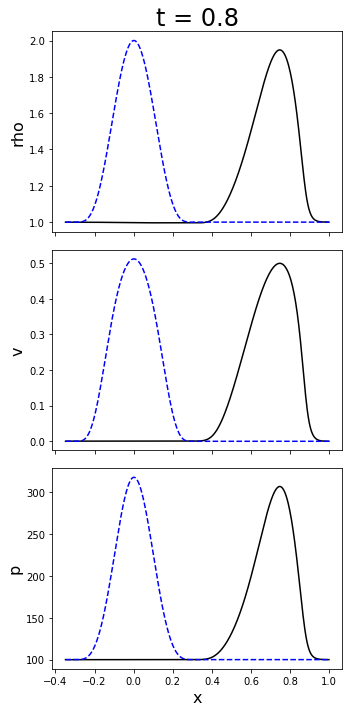

In [36]:
#          (N  ,a,b,t,cfl,p_l,  p_r  ,rho_l,rho_r,v_l,v_r)
test=Hydro(500,-0.35,1,0,0.5,13.33,1e-8,10.0,  1.0,0.0,0.0)
#ax=test.densplot()

test.evolve(0.8)
#ay=test.plot()
test.plot()
plt.show()

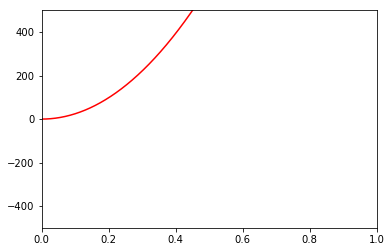

In [44]:
gamma=5/3
D=test.U[0][300]
S=test.U[1][300]
T=test.U[2][300]
def f(v):
    return ((gamma*v*(T-S*v+D)-S*(1-v**2))**2 - (v**2)*(1-v**2)*(D**2)*(gamma-1)**2)
v=np.arange(-1,1,0.001)
plt.plot(v,f(v),'r-')
plt.ylim(-500,500)
plt.xlim(0,1)
plt.show()